In [20]:
import numpy as np
from osgeo import gdal,ogr, gdalconst
import subprocess
import glob
import os
from datetime import datetime
import matplotlib.pyplot as plt
import utm

In [2]:
folder_dir = '/Users/bvarugu/Documents/Belomonte/Xingu_68_598_DPHR/VV_tifs'
slc_list = glob.glob(folder_dir+'/*_VV.tif');

for slc in slc_list:
    
    date = os.path.basename(slc).split('_')[2][0:8]
    print(date)

20191101
20211021
20191008
20221028
20201026
20181013
20171018
20160121
20161011
20181025
20171030
20211009
20201002
20161023
20231023
20230929
20221016


In [27]:
def extract_date_from_filename(filename):
    date_str = os.path.basename(slc).split('_')[2][0:8];
    try:
        return datetime.strptime(date_str, "%Y%m%d")
    except ValueError:
        print(f"Failed to parse date from filename: {filename}")
        return None
    
def find_nearest_date_file(directory_path, target_date):
    nearest_date_diff = None
    nearest_date_file = None

    for filename in os.listdir(directory_path):
        if os.path.isfile(os.path.join(directory_path, filename)) and filename.lower().endswith('.tif'):
            extracted_date = extract_date_from_filename(filename)
            if extracted_date:
                date_diff = abs(extracted_date - target_date)
                if nearest_date_diff is None or date_diff < nearest_date_diff:
                    nearest_date_diff = date_diff
                    nearest_date_file = os.path.join(directory_path, filename)
    return nearest_date_file

folder_dir = '/Users/bvarugu/Documents/Belomonte/Xingu_68_598_DPHR/VV_tifs';
target_path = '/Users/bvarugu/Documents/Belomonte/Xingu_68_599_DPHR/VV_tifs';
merged_file_dir = '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs'
slc_list = glob.glob(folder_dir+'/*_VV.tif');

for slc in slc_list:
    slc1_date = extract_date_from_filename(slc);
    slc_file_2 =  find_nearest_date_file(target_path, slc1_date);
    slc2_date = extract_date_from_filename(slc_file_2);
    out_name = merged_file_dir+'/'+slc1_date.strftime("%Y%m%d")+'_604_599_merged_VV.tif'
    command = f"gdal_merge.py -o {out_name} {slc} {slc_file_2}"
    print(command.split())

    subprocess.run(command.split())

['gdal_merge.py', '-o', '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20191101_604_599_merged_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_598_DPHR/VV_tifs/S1A_IW_20191101T090641_DVP_RTC10_G_gdufed_4166_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_599_DPHR/VV_tifs/S1A_IW_20201002T090622_DVP_RTC10_G_gdufed_4E3B_VV.tif']
0...10...20...30...40...50

/Users/bvarugu/Documents/UTILITIES/miniconda3/bin/gdal_merge.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').run_script('GDAL==3.3.1', 'gdal_merge.py')


...60...70...80...90...100 - done.
['gdal_merge.py', '-o', '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20211021_604_599_merged_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_598_DPHR/VV_tifs/S1A_IW_20211021T090653_DVP_RTC10_G_gdufed_426D_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_599_DPHR/VV_tifs/S1A_IW_20201002T090622_DVP_RTC10_G_gdufed_4E3B_VV.tif']
0...10...20...30...40...50

/Users/bvarugu/Documents/UTILITIES/miniconda3/bin/gdal_merge.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').run_script('GDAL==3.3.1', 'gdal_merge.py')


...60...70...80...90...100 - done.
['gdal_merge.py', '-o', '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20191008_604_599_merged_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_598_DPHR/VV_tifs/S1A_IW_20191008T090641_DVP_RTC10_G_gdufed_3E7C_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_599_DPHR/VV_tifs/S1A_IW_20201002T090622_DVP_RTC10_G_gdufed_4E3B_VV.tif']
0...10...20...30...40...50

/Users/bvarugu/Documents/UTILITIES/miniconda3/bin/gdal_merge.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').run_script('GDAL==3.3.1', 'gdal_merge.py')


...60...70...80...90...100 - done.
['gdal_merge.py', '-o', '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20221028_604_599_merged_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_598_DPHR/VV_tifs/S1A_IW_20221028T090656_DVP_RTC10_G_gdufed_940D_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_599_DPHR/VV_tifs/S1A_IW_20201002T090622_DVP_RTC10_G_gdufed_4E3B_VV.tif']
0...10...20...30...40...50...60...70...80...90...100 - done.
['gdal_merge.py', '-o', '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20201026_604_599_merged_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_598_DPHR/VV_tifs/S1A_IW_20201026T090647_DVP_RTC10_G_gdufed_2991_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_599_DPHR/VV_tifs/S1A_IW_20201002T090622_DVP_RTC10_G_gdufed_4E3B_VV.tif']


/Users/bvarugu/Documents/UTILITIES/miniconda3/bin/gdal_merge.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').run_script('GDAL==3.3.1', 'gdal_merge.py')


0...10...20...30...40...50

/Users/bvarugu/Documents/UTILITIES/miniconda3/bin/gdal_merge.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').run_script('GDAL==3.3.1', 'gdal_merge.py')


...60...70...80...90...100 - done.
['gdal_merge.py', '-o', '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20181013_604_599_merged_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_598_DPHR/VV_tifs/S1A_IW_20181013T090634_DVP_RTC10_G_gdufed_1FA2_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_599_DPHR/VV_tifs/S1A_IW_20201002T090622_DVP_RTC10_G_gdufed_4E3B_VV.tif']
0...10...20...30...40...50

/Users/bvarugu/Documents/UTILITIES/miniconda3/bin/gdal_merge.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').run_script('GDAL==3.3.1', 'gdal_merge.py')


...60...70...80...90...100 - done.
['gdal_merge.py', '-o', '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20171018_604_599_merged_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_598_DPHR/VV_tifs/S1A_IW_20171018T090628_DVP_RTC10_G_gdufed_0C25_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_599_DPHR/VV_tifs/S1A_IW_20201002T090622_DVP_RTC10_G_gdufed_4E3B_VV.tif']
0...10...20...30...40...50

/Users/bvarugu/Documents/UTILITIES/miniconda3/bin/gdal_merge.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').run_script('GDAL==3.3.1', 'gdal_merge.py')


...60...70...80...90...100 - done.
['gdal_merge.py', '-o', '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20160121_604_599_merged_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_598_DPHR/VV_tifs/S1A_IW_20160121T090609_DVP_RTC10_G_gdufed_6A58_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_599_DPHR/VV_tifs/S1A_IW_20201002T090622_DVP_RTC10_G_gdufed_4E3B_VV.tif']
0...10...20...30...40...50

/Users/bvarugu/Documents/UTILITIES/miniconda3/bin/gdal_merge.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').run_script('GDAL==3.3.1', 'gdal_merge.py')


...60...70...80...90...100 - done.
['gdal_merge.py', '-o', '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20161011_604_599_merged_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_598_DPHR/VV_tifs/S1A_IW_20161011T090621_DVP_RTC10_G_gdufed_5293_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_599_DPHR/VV_tifs/S1A_IW_20201002T090622_DVP_RTC10_G_gdufed_4E3B_VV.tif']
0...10...20...30...40...50

/Users/bvarugu/Documents/UTILITIES/miniconda3/bin/gdal_merge.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').run_script('GDAL==3.3.1', 'gdal_merge.py')


...60...70...80...90...100 - done.
['gdal_merge.py', '-o', '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20181025_604_599_merged_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_598_DPHR/VV_tifs/S1A_IW_20181025T090634_DVP_RTC10_G_gdufed_F772_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_599_DPHR/VV_tifs/S1A_IW_20201002T090622_DVP_RTC10_G_gdufed_4E3B_VV.tif']
0...10...20...30...40...50

/Users/bvarugu/Documents/UTILITIES/miniconda3/bin/gdal_merge.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').run_script('GDAL==3.3.1', 'gdal_merge.py')


...60...70...80...90...100 - done.
['gdal_merge.py', '-o', '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20171030_604_599_merged_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_598_DPHR/VV_tifs/S1A_IW_20171030T090628_DVP_RTC10_G_gdufed_8DA5_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_599_DPHR/VV_tifs/S1A_IW_20201002T090622_DVP_RTC10_G_gdufed_4E3B_VV.tif']
0...10...20...30...40...50

/Users/bvarugu/Documents/UTILITIES/miniconda3/bin/gdal_merge.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').run_script('GDAL==3.3.1', 'gdal_merge.py')


...60...70...80...90...100 - done.
['gdal_merge.py', '-o', '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20211009_604_599_merged_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_598_DPHR/VV_tifs/S1A_IW_20211009T090653_DVP_RTC10_G_gdufed_0684_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_599_DPHR/VV_tifs/S1A_IW_20201002T090622_DVP_RTC10_G_gdufed_4E3B_VV.tif']
0...10...20...30...40...50

/Users/bvarugu/Documents/UTILITIES/miniconda3/bin/gdal_merge.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').run_script('GDAL==3.3.1', 'gdal_merge.py')


...60...70...80...90...100 - done.
['gdal_merge.py', '-o', '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20201002_604_599_merged_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_598_DPHR/VV_tifs/S1A_IW_20201002T090647_DVP_RTC10_G_gdufed_115D_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_599_DPHR/VV_tifs/S1A_IW_20201002T090622_DVP_RTC10_G_gdufed_4E3B_VV.tif']
0...10...20...30...40...50

/Users/bvarugu/Documents/UTILITIES/miniconda3/bin/gdal_merge.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').run_script('GDAL==3.3.1', 'gdal_merge.py')


...60...70...80...90...100 - done.
['gdal_merge.py', '-o', '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20161023_604_599_merged_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_598_DPHR/VV_tifs/S1A_IW_20161023T090621_DVP_RTC10_G_gdufed_FFE4_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_599_DPHR/VV_tifs/S1A_IW_20201002T090622_DVP_RTC10_G_gdufed_4E3B_VV.tif']
0...10...20...30...40...50...60...70...80...90...100 - done.
['gdal_merge.py', '-o', '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20231023_604_599_merged_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_598_DPHR/VV_tifs/S1A_IW_20231023T090701_DVP_RTC10_G_gdufed_F3E3_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_599_DPHR/VV_tifs/S1A_IW_20201002T090622_DVP_RTC10_G_gdufed_4E3B_VV.tif']


/Users/bvarugu/Documents/UTILITIES/miniconda3/bin/gdal_merge.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').run_script('GDAL==3.3.1', 'gdal_merge.py')


0...10...20...30...40...50

/Users/bvarugu/Documents/UTILITIES/miniconda3/bin/gdal_merge.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').run_script('GDAL==3.3.1', 'gdal_merge.py')


...60...70...80...90...100 - done.
['gdal_merge.py', '-o', '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20230929_604_599_merged_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_598_DPHR/VV_tifs/S1A_IW_20230929T090701_DVP_RTC10_G_gdufed_B1C6_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_599_DPHR/VV_tifs/S1A_IW_20201002T090622_DVP_RTC10_G_gdufed_4E3B_VV.tif']
0...10...20...30...40...50

/Users/bvarugu/Documents/UTILITIES/miniconda3/bin/gdal_merge.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').run_script('GDAL==3.3.1', 'gdal_merge.py')


...60...70...80...90...100 - done.
['gdal_merge.py', '-o', '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20221016_604_599_merged_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_598_DPHR/VV_tifs/S1A_IW_20221016T090656_DVP_RTC10_G_gdufed_2DA9_VV.tif', '/Users/bvarugu/Documents/Belomonte/Xingu_68_599_DPHR/VV_tifs/S1A_IW_20201002T090622_DVP_RTC10_G_gdufed_4E3B_VV.tif']
0...10...20...30...40...50...60...70...80...90...100 - done.


/Users/bvarugu/Documents/UTILITIES/miniconda3/bin/gdal_merge.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').run_script('GDAL==3.3.1', 'gdal_merge.py')


In [6]:

# Example usage
merged_file_dir = '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs'
merged_slc_list = glob.glob(merged_file_dir+'/*_VV.tif');
subset_file_dir = '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/subset_tifs';
bbox = [333550,9588140,441429,9712773]  # Example bounding box (min lon, min lat, max lon, max lat)
for slc in merged_slc_list:
    
    output_path = subset_file_dir+'/'+'subset_'+os.path.basename(slc);
    command = 'gdalwarp -te {} {} {} {} {} {}'.format(bbox[0],bbox[1],bbox[2],bbox[3],slc,output_path);
    subprocess.run(command.split());

print("Subsetting completed!")

Creating output file that is 10788P x 12463L.
Processing /Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20221028_604_599_merged_VV.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 10788P x 12463L.
Processing /Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20201026_604_599_merged_VV.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 10788P x 12463L.
Processing /Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20181025_604_599_merged_VV.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 10788P x 12463L.
Processing /Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/20201002_604_599_merged_VV.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 10788P x 12463L.
Processing /Users/bvarugu/Documents/Belomonte/Xingu_68_604

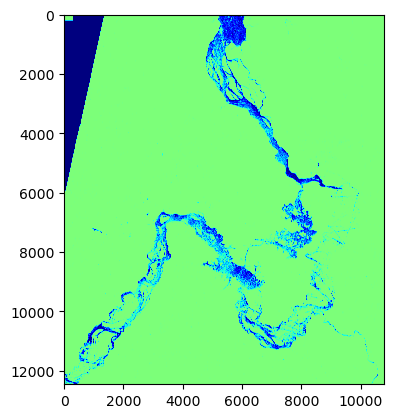

In [16]:
def generate_land_water_mask(rtc_image_path,threshold,save=None,output_mask_path=None):
    """
    Generates a land-water mask from a Sentinel-1 RTC image.

    Args:
        rtc_image_path: Path to the Sentinel-1 RTC image file.

    Returns:
        A NumPy array representing the land-water mask, where 1 indicates land and 0 indicates water.
    """

    # Open the RTC image using GDAL
    dataset = gdal.Open(rtc_image_path)
    if dataset is None:
        raise Exception("Failed to open image:", rtc_image_path)

    # Get image data and band information
    band = dataset.GetRasterBand(1)  # Assuming VH polarization is in the first band
    data = band.ReadAsArray();
    

    # Apply thresholding for land-water separation (adjust threshold as needed)
    #threshold = -20  # dB - adjust based on image characteristics
    land_mask = np.where(data > threshold, 1, 0);
    
    if save==True:
        driver = gdal.GetDriverByName("GTiff");
        options = ["COMPRESS=LZW"];
        geotransform = dataset.GetGeoTransform();
        projection = dataset.GetProjection();
        dset = driver.Create(output_mask_path, land_mask.shape[1], land_mask.shape[0], 1, gdal.GDT_Int32, options);
        dset.GetRasterBand(1).WriteArray(land_mask);
        dset.SetGeoTransform(geotransform);
        dset.SetProjection(projection);
        # Close the dset
        dset = None
    # Close the dataset
    dataset = None

    # Return the land-water mask
    return land_mask
subset_file_dir = '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/subset_tifs';
subset_slc_list = glob.glob(subset_file_dir+'/*_VV.tif')[0:2];
output_mask = '/Users/bvarugu/Documents/Belomonte/Xingu_68_604_599_merged/VV_tifs/subset_tifs/land_water_mask1.tif'
land_water_mask = generate_land_water_mask(subset_slc_list[0],-20,output_mask_path=output_mask,save=True);

plt.imshow(land_water_mask,cmap='jet',vmin=0,vmax=2)


In [32]:
def get_geo_bounds(raster):
    dataset = gdal.Open(raster);
    ulx, xres, xskew, uly, yskew, yres  = dataset.GetGeoTransform();
    #print(dataset.GetProjection())
    lrx = ulx + (dataset.RasterXSize * xres);
    lry = uly + (dataset.RasterYSize * yres);
    dataset=None
    
    uly, ulx = utm.to_latlon(ulx, uly, 22, northern=False);
    lry, lrx = utm.to_latlon(lrx, lry, 22, northern=False);
    return ulx, uly , lrx, lry

geo_box = get_geo_bounds(output_mask);
print(geo_box)
    
    

(-52.497201722183405, -2.5977229791381777, -51.527462871534695, -3.7260154050686163)


In [48]:
## Make folium map
import folium
import branca
from folium import plugins
from matplotlib import cm
from PIL import ImageColor

lat_mean = np.mean([geo_box[1],geo_box[3]]).astype(np.float64)
lon_mean = np.mean([geo_box[0],geo_box[2]]).astype(np.float64)
map_bounds = [[geo_box[1], geo_box[0]],
             [geo_box[3], geo_box[2]]];

#Folium Map
map = folium.Map(width=1100, height=600, 
                 location=(lat_mean, lon_mean), 
                 zoom_start=10,
                 tiles='Stamen Terrain',attr='https://mt1.google.com/');
#Basemaps
#Add custom basemaps
for basemap in basemaps:
    basemaps[basemap].add_to(map)

palette = ['blue', 'green']#[::-1]  
cmap = branca.colormap.LinearColormap(colors=palette,
                         vmin=0,
                         vmax=1,
                         caption='Image Colormap')

folium.raster_layers.ImageOverlay(land_water_mask,
                                  opacity=0.5,
                                  bounds=map_bounds,
                                  name='2016_mask',
                                  colormap=cmap).add_to(map);
#Colorbar
folium_colormap = map.add_child(cmap)
# #layer Control
# map.add_child(folium.LayerControl())
#Display map
map

In [47]:
# Add custom base maps to folium
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = False,
        control = True,
        show = False,
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True,
        opacity = 0.8,
        show = False
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = False,
        control = True,
        show = False,
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True,
        opacity = 0.8,
        show = False
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True,
        opacity = 0.8,
        show = True
    )
}